# Ridge Regression with Gradient Descent

### Author: Juan Solorio

-----

# Overview
In this exercise, I will implement a first version of my own gradient descent algorithm to
solve the ridge regression problem. I will keep improving and extending this gradient descent optimization algorithm. In this notebook, I will implement a basic version of the algorithm.

## Objectives
- Mathematically define _Objective Function_ for Ridge Regression ($F\beta$)
    - Compute gradiant $\nabla F$
- Create functions for algorithm:
    - Objective function
    - Gradient function
    - Gradient Descent funtion
- Observe (plot) the convergence in terms of the function values and the gradients  
    and tune for the optimal hyperparameters for step-size ($\eta$) and normalization ($\lambda$)
- Compare to _sklearn_


## Environment Setup - *Importing Libraries*

In [1]:
# needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
import time

%matplotlib inline
plt.style.use('ggplot')

# Background and Theory

We start by defining the ___Linear Regression___ as a supervised learning algorithm and we write the mathematical algorithm as:
$$
y = b_0*x + b_1
$$
> y - target value  
$b_0$ - slope  
x - predictor variable  
$b_1$ - intercept

where $m$ and $b$ are the variables the algorithm will try to predict from the data.

We can generalize this equation for multiple variables and write our _cost function_ to optimize our algorithm as:

$$
F(\beta) = \frac{1}n\sum_{i=1}^n(y_i - h(x_i))^2 \\
\\
\\
h(x_i) = x_1\beta_1 + x_2\beta_2 + ... + x_{i,j}\beta_j
$$

Where $h(x_i)$ is the predicted value for the function, $\beta$ are the weights for the individual variables, and $y_i$ is the target value of the data.

We can finalize this by writing the equation in the expanded form:
$$
F(\beta) = \frac{1}n\sum_{i=1}^n(y_i - \sum_{j=1}^dx_{ij}\beta_j)^2
$$

## Lasso Regression

Linear Regression treats all the features equally and finds unbiased weights to minimizes the cost function.
In _Ridge Regression_ , there is an addition of l2 penalty ( square of the magnitude of weights ) in the cost function of Linear Regression:


$$
\lambda\|\beta\|^2_2

$$

Where $\lambda$ is a hyperparameter to be tuned and this is done so that the model does not overfit the data.  

We can write the final objective equation as:


$$
F(\beta) = \frac{1}n\sum_{i=1}^n(y_i - \sum_{j=1}^dx_{ij}\beta_j)^2 + \lambda\sum_{j=1}^d\beta_j^2
$$


## Gradient Descent
Gradient descent is an optimization algorithm used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. In machine learning, we use gradient descent to update the parameters or weights ($\beta$) of our model.

In order to  minimize with respect to $\beta$, we want to take the derivative of $F(\beta)$ and set it equal to zero. 

The derivative for $n=1$ and $d=1$ yields:
\begin{equation}
\frac{dF}{d\beta} = \frac{2}n(y - x\beta) + 2\lambda\beta
\end{equation}

and for $n>1$ and $d>1$


$$
\frac{\partial F}{\partial \beta_j} = \frac{\partial}{\partial \beta_j} (\frac{1}n\sum_{i=1}^n(y_i - x^T_{i}\beta_j)^2 + \lambda\|\beta\|^2_2)
$$
$$
= \frac{1}n(\sum_{i=1}^n \frac{\partial}{\partial \beta_j} (y_i - x^T_{i}\beta_j)^2 + \frac{\partial}{\partial \beta_j} \lambda\|\beta\|^2_2)
$$
$$
= -\frac{2}n(\sum_{i=1}^n x_{ij} (y_i - x^T_{i}\beta_j)) + 2\lambda\sum_{j=1}^d\beta_j
$$



In Matrix terms, $F(\beta)$ can be interpreted as:


$$
F(\beta) = \frac{1}{n}<Y - X\beta,Y-X\beta> + \lambda\|\beta\|^2_2
$$


Taking the derivative of the matrix form of $F(\beta)$ leads us to the following:


$$
\nabla F = \frac{\partial}{\partial\beta} F= - \frac{2}{n}X^T(y + X\beta) + 2\lambda\beta
$$


Which is also known as the _gradient_ of the _objective function_ $F$.


# Algorithm Functions Definitions

* Objective function for Ridge Regression $F(\beta)$:

>$$
F(\beta) = \frac{1}n\sum_{i=1}^n(y_i - X^T_{ij} \cdot \beta_j)^2 + \lambda\|\beta_j\|^2_2
$$

In [2]:
def obj_fx(beta,lamda,X,y):
    """
    Linear regression with Ridge penalty L1:
    F(b) = 1/n sum((y - x dotproduct b)^2) + lamda*norm(b)^2
    
    Parameters
    ----------
    beta : arr
        array of values for weights
    lamda : int
        interger value for normalization parameter
    X : arr
        array of features from data
    y : arr
        array of target values from data

    Returns
    -------
    int
        computation of the objective function

    """
    
    # dot product can be accomplish by 'numpy_arrayA @ numpy_arrayB' or 'numpy_arrayA.dot(numpy_arrayB)'
    return 1/len(y) * sum((y - X @ beta)**2) + lamda*np.linalg.norm(beta)**2

* Gradient of objective funtion - $\nabla F$:
>$$
\nabla F = \frac{\partial}{\partial\beta} F= - \frac{2}{n}X^T(y + X\beta) + 2\lambda\beta
$$

In [3]:
def gradient_fx(beta,lamda,X,y):
    """
    Computes gradient of the Linear regression with Ridge penalty L1 function:
    grad F(b) = -2/n (x.T dotproduct (y - x dotproduct b)) + 2*lamda*b
    
    Parameters
    ----------
    beta : arr
        array of values for weights
    lamda : int
        interger value for normalization parameter
    X : arr
        array of features from data
    y : arr
        array of target values from data

    Returns
    -------
    int
        computation of the gradient of Ridge regression objective function

    """
    return (-2/len(y)) * X.T @ (y - X @ beta) + 2*lamda*beta 

* Gradient Descent Algorith:
>`Gradient Descent algorithm with fixed constant step-size  
__input__  step-size $\eta$  
__initialization__ $\beta_0 = 0$  
__repeat for__ t = 0, 1, 2, . . .  
    $\beta_{t+1} = \beta_t − \eta \nabla F(\beta_t)$  
__until__ the stopping criterion $\|\nabla F\| \leq \epsilon$ is satisfied.


In [4]:
def gradient_descent(beta_init, eta ,lamda,X,y,epsilon=0.005):
    """
    Computes gradient descent with a fixed step size eta and stopping condition norm gradient F < epislon
    
    Parameters
    ----------
    beta_init : arr
        array of values for weights as starting point
    eta : int
        interger value for step size parameter
    lamda : int
        interger value for normalization parameter
    X : arr
        array of features from data
    y : arr
        array of target values from data
    epsilon : int
        interger value for stopping parameter condition, defaul = 0.005

    Returns
    -------
     beta_vals: Matrix 
         Estimated betas at each iteration, with the most recent values in the last row
    """
    # setting initial value of betas
    beta = beta_init
    # gradient calculation for starting values
    gradient = gradient_fx(beta,lamda,X,y)
    # list to save beta values 
    beta_vals = [beta_init]
    # loop for stopping criterion epsilon
    while np.linalg.norm(gradient) > epsilon:
        # updating values for beta and gradient
        beta = beta - eta*gradient
        gradient = gradient_fx(beta,lamda,X,y)
        
        # appending values
        beta_vals.append(beta)
    return np.array(beta_vals)

# Implementation
For our data, we'll use the ***Hitters*** dataset from `'https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'`, and we'll drop any rows with `NA` values.

In [5]:
# Load the data
hitters = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv',
                      sep=',', header=0)
hitters = hitters.dropna()
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


We are going to attempt to use our Ridge Regression algorithm to try and predict the _Salary_ of a player based on all the other features in the dataset. We want to create our _Features_ (X) and _Target_ (y) datasets.

In [6]:
# Creating matrix X with the predictors and 
# and vector y with the response 
X = hitters.drop('Salary', axis=1)
# need to transform our labels for 'League','Division','NewLeague' to bool or {1,0} values
X = pd.get_dummies(X, drop_first=True) 
y = hitters.Salary

X.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,1,0,1


We now need to split our data into _train_ and _test_ sets for both the features and target variables. Given the values in our _Features_ vary in size or magnitude, we need to standardize our features by using the sklearn function `preprocessing.StandardScaler()`.

In [7]:
# Dividing the data into train and test sets.
# By default,  it is a 75-25 split between train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Standarizing the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler = preprocessing.StandardScaler().fit(y_train.values.reshape(-1, 1))
y_train = scaler.transform(y_train.values.reshape(-1, 1)).reshape((-1))
y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape((-1))

In [8]:
def convergence_plots(x_vals, lambduh, X,y,title):
    """
    Plot the convergence in terms of the function values and the gradients
    Input:
    - x_vals: Values the gradient descent algorithm stepped to
    """
    n, d = x_vals.shape
    fs = np.zeros(n)
    grads = np.zeros((n, d))
    for i in range(n):
        fs[i] = obj_fx(x_vals[i], lambduh,X,y)
        grads[i, :] = gradient_fx(x_vals[i], lambduh,X,y)
    grad_norms = np.linalg.norm(grads, axis=1)
    
    fig_dims = (15, 3)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_dims)

    ax1.plot(fs)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Objective value')
    
    ax2.plot(grad_norms)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Norm of gradient')
    plt.suptitle(title,fontsize=16)
    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
    plt.show()


/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in matmul
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in matmul
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in square
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in matmul
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in mat

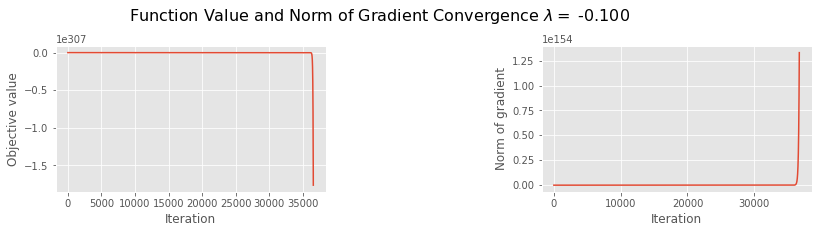

Total runtime of the program is 19.260648012161255


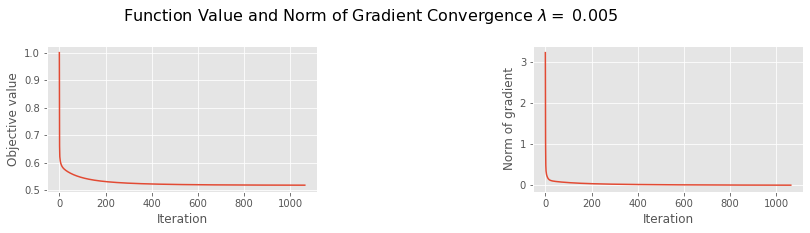

Total runtime of the program is 2.0314691066741943


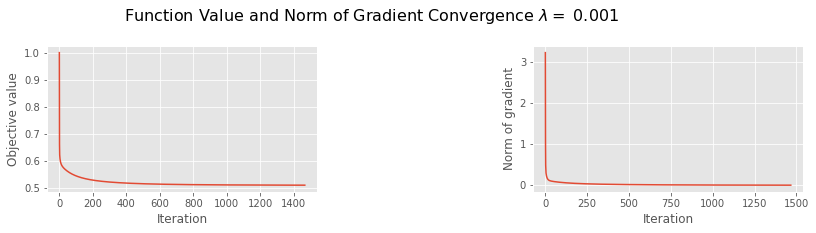

Total runtime of the program is 2.0567688941955566


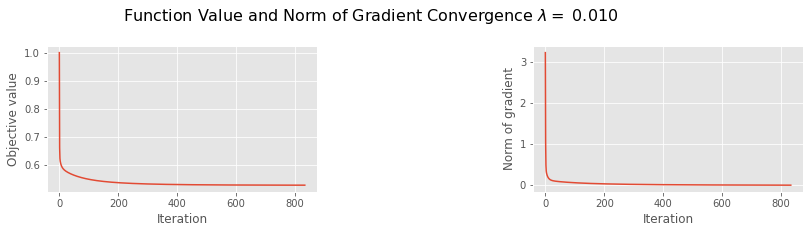

Total runtime of the program is 1.7774415016174316


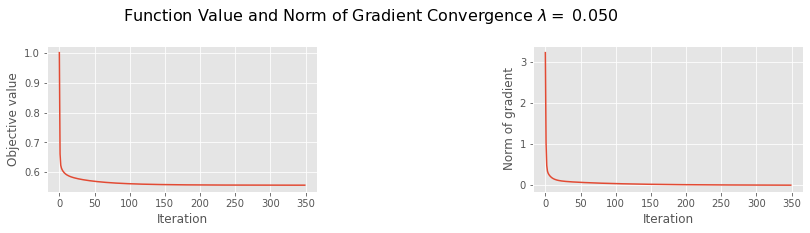

Total runtime of the program is 1.7836413383483887


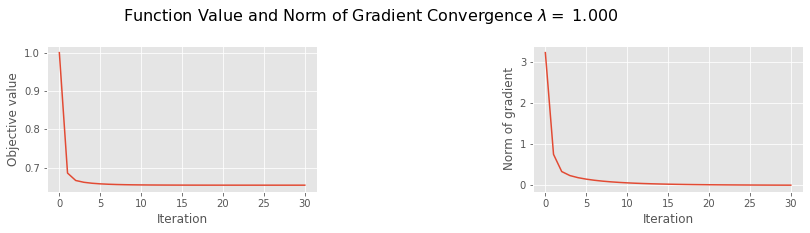

Total runtime of the program is 1.6427910327911377


In [9]:
eta = 0.05
lambdas = [-0.1, 0.005,0.001,0.01,0.05,1]
d = X_train.shape[1]
beta_init = np.zeros(d)
for lambduh in lambdas:
    # store starting time 
    begin = time.time() 
    betas = gradient_descent(beta_init=beta_init, eta=eta, lamda=lambduh,X=X_train,y=y_train)
    title=r'Function Value and Norm of Gradient Convergence $\lambda =$ {:.3f}'.format(lambduh)
    convergence_plots(betas, lambduh,X_train, y_train, title)

    time.sleep(1) 
    # store end time 
    end = time.time() 
  
    # total time taken 
    print(f"Total runtime of the program is {end - begin}") 

We see that the _Objective value_ of the function diverges when the normalization parameter $\lambda$ is negative and that it converges to about _0.5_ when tha values of $\lambda=[0.001,0.05]$. The best run time occured for $\lambda=0.01$, so we'll use this as our _Optimal_ normalization parameter value.

# Comparing to _Scikit-Learn_

We can compute the ridge regression model from sklearn by using the `Ridge` function from **sklearn.linear_model** and compare how our model performed. 

_Note that the scikit-learn [objective function](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) is_ :

$$
F^*(\beta) = \min_{\beta \in \mathbb{R}^d} \sum_{i=1}^n(y_i - \sum_{j=1}^dx_{ij}\beta_j)^2 + \alpha\sum_{j=1}^d\beta_j^2
$$

when comparing sklearn's objective function $F^*(\beta)$ to our objective function $F(\beta)$, we get that:
> $\lambda = \frac{\alpha}{n} \Longrightarrow \alpha = n * \lambda$

In [10]:
# number of samples n
n = len(y_train)
lambduh = 0.01
betas = gradient_descent(beta_init=beta_init, eta=eta, lamda=lambduh,X=X_train,y=y_train)
# setting alpha for sklearn ridge 
alpha = n*lambduh
ridge = Ridge(alpha=alpha, fit_intercept=False) # initializing ridge
ridge.fit(X_train, y_train) # training ridge model
# printing beta values
print("Sklearn Final weights (betas): ", ridge.coef_)
print("Our Final weights (betas): ", betas[-1])


Sklearn Final weights (betas):  [-0.49683318  0.53848371  0.14026802 -0.09125083  0.01367849  0.28982753
 -0.10561524 -0.22109841  0.49775465 -0.05474063  0.53958547  0.06559602
 -0.37105594  0.14704651  0.09250802 -0.09098076  0.04637135 -0.12793725
 -0.01498699]
Our Final weights (betas):  [-0.48507163  0.51545023  0.1336241  -0.07385865  0.01975817  0.28526168
 -0.11787016 -0.12322043  0.4547416  -0.05871632  0.49069089  0.06869243
 -0.36495034  0.14618957  0.08881195 -0.09213196  0.04644374 -0.12970797
 -0.0157561 ]


In [11]:
print("Objective value from Sklearn F*(beta): ", obj_fx(ridge.coef_, lambduh,X_train,y_train))
print("Objective value from our F(beta): ", obj_fx(betas[-1], lambduh,X_train,y_train))


Objective value from Sklearn F*(beta):  0.5261102696078659
Objective value from our F(beta):  0.5263969771608789


The values for our final _feature weights_ ($\beta$ 's) and _objective function_ from our algorithms match pretty well with those produced by _Sklearn_ functions.

We can now predict values for our _tests_ datasets and see how well our model's predictions compare to the expected values. Sklearn has the built in function `.predict` for all it's supervised learning models, we can recreate the function by computing the _dot product_ of the features and the weights.

In [12]:
def predict_values(betas, X):
    """
    Function calculates the predicted target values for dot product for given betas and features (X)
    
    Parameters
    ----------
    beta_init : arr
        array of values for weights 
    X : arr
        array of features from data

    Returns
    -------
     Calculated predicted values for target variable, from dot product of features and weights
    """
    return X.dot(betas)

In [13]:
# getting a dataframe of the predicted values for both my own algorithm and sklearn
# for the test dataset
predicted_data = pd.DataFrame(np.array([ridge.predict(X_test), predict_values(betas[-1],X_test), y_test]).T, 
                              columns=['Sklearn Ridge','Own Ridge','Expected Values']).melt(id_vars=['Expected Values']).rename(
    columns={'variable':'ML algorithm','value':'Predicted Values'})
predicted_data.head()

,Expected Values,ML algorithm,Predicted Values
0,0.289100,Sklearn Ridge,0.030257
1,-0.079887,Sklearn Ridge,1.323443
2,-0.811811,Sklearn Ridge,-1.026751
3,1.402108,Sklearn Ridge,0.250032
4,-0.769468,Sklearn Ridge,0.114917


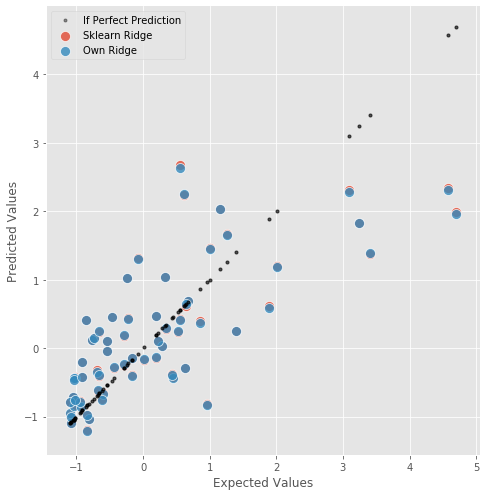

In [14]:
# plot comparing both how well do my algorithm compares to sklean's predictions
# and comparing how well the predictions are compared to the actual expected values (diagonal scatter)
sns.color_palette("colorblind")
g = sns.FacetGrid(predicted_data,hue='ML algorithm', height = 7,aspect=1)
g = g.map(sns.scatterplot, "Expected Values", "Predicted Values", edgecolor="w",s=100,alpha=.8)
plt.plot(predicted_data['Expected Values'],predicted_data['Expected Values'],'k.',linewidth=1.5,
         alpha=.4,label='If Perfect Prediction')
plt.legend()
plt.show()

We can again see that the values from our model compared very well to those from the sklearn model, and both models aline with the expected values' overall trend, but do appear to have greater error or diverge from the expected values the higher the "Salary". 

Let's finally just check the distribution of the percent difference for the predicted from expected values, we'll first rescale the predicted values back to the original sample values.

In [15]:
# scaling back to the actual salary values
salary_sklearn = np.round(scaler.inverse_transform(ridge.predict(X_test)))
salary_own = np.round(scaler.inverse_transform(predict_values(betas[-1],X_test)))
salary = scaler.inverse_transform(y_test)

Percent of values with less than 50% error: 57 %


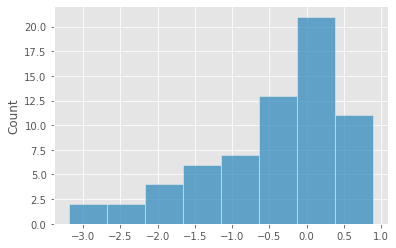

In [16]:
# checking the error distribution
print("Percent of values with less than 50%% error: %2d %%"%(100*np.mean(abs(salary-salary_own)/salary <= 0.5)))
sns.histplot(((salary-salary_own)/salary))

We can see that about 57% of our values have less than or equal to "50%" difference from the expected values, and from the scatter plot again we can see how at smaller salaries we have some higher predicted salaries and we tend to under predict values as the salaries increase.